In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_jan_path =  "../data/raw/yellow_tripdata_2016-01.csv"
df_feb_path =  "../data/raw/yellow_tripdata_2016-02.csv"
df_mar_path =  "../data/raw/yellow_tripdata_2016-03.csv"

df_jan = dd.read_csv(df_jan_path, assume_missing=True)
df_feb = dd.read_csv(df_feb_path, assume_missing=True)
df_mar  = dd.read_csv(df_mar_path, assume_missing=True)

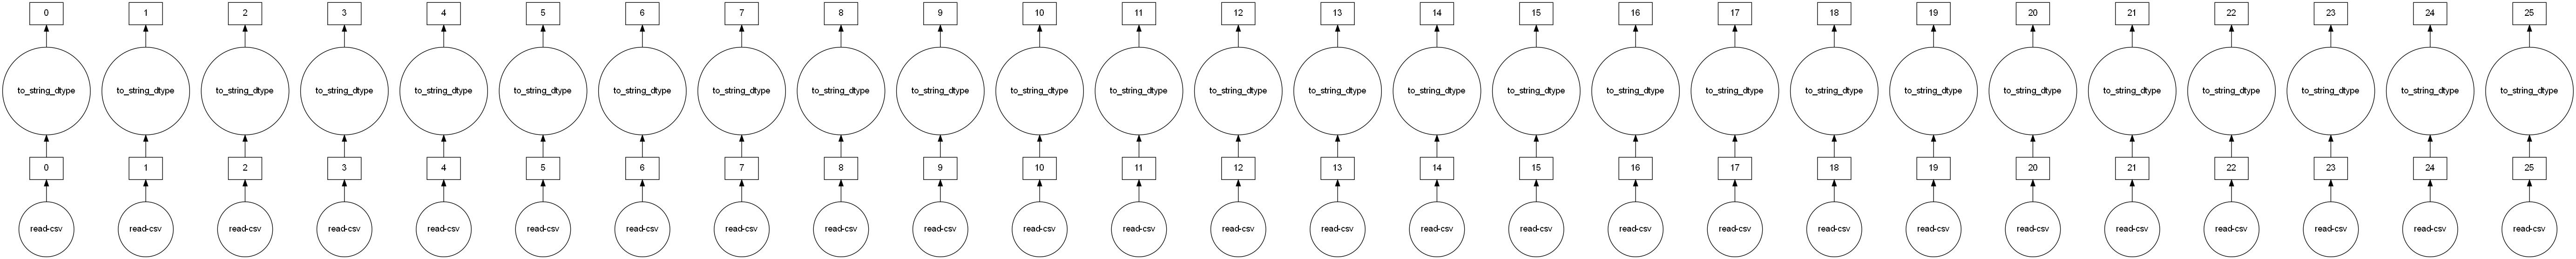

In [3]:
df_jan.visualize(tasks=True)

In [4]:
print("Shape of January dataset: ",df_jan.shape)
print("Shape of Febraury dataset: ",df_feb.shape)
print("Shape of March dataset: ",df_mar.shape)

Shape of January dataset:  (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(2f74708)).size() // 19, dtype=int64>, 19)
Shape of Febraury dataset:  (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(897f02d)).size() // 19, dtype=int64>, 19)
Shape of March dataset:  (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(1dbb5b9)).size() // 19, dtype=int64>, 19)


In [12]:
df_final = dd.concat(dfs=[df_jan, df_feb, df_mar], axis=0).drop(
    columns=['extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
             'improvement_surcharge', 'total_amount', 'payment_type'])

In [5]:
import numpy as np
import dask.dataframe as dd

np.random.seed(42)

# ============================================
# PART 1: COORDINATE TRANSFORMATION (NYC → KARACHI)
# Pure transformation without boundary checks
# ============================================

# KARACHI GEOGRAPHIC BOUNDARIES
khi_lat_min, khi_lat_max = 24.72, 25.00
khi_lng_min, khi_lng_max = 66.90, 67.28

# MAJOR KARACHI HOTSPOTS
neighborhoods = {
    'I_I_Chundrigar_Road': (24.8478, 67.0210),
    'Saddar': (24.8546, 67.0277),
    'Clifton': (24.8092, 67.0302),
    'DHA_Phase_1': (24.8135, 66.9909),
    'DHA_Phase_2': (24.8246, 67.0272),
    'DHA_Phase_4': (24.8011, 67.0581),
    'DHA_Phase_5': (24.8119, 67.0709),
    'DHA_Phase_6': (24.7912, 67.0843),
    'DHA_Phase_8': (24.8123, 67.1012),
    'Gulshan_e_Iqbal': (24.9147, 67.0946),
    'Gulistan_e_Jauhar': (24.9234, 67.1342),
    'North_Nazimabad': (24.9313, 67.0374),
    'PECHS': (24.8732, 67.0682),
    'Bahadurabad': (24.8820, 67.0764),
    'Tariq_Road': (24.8602, 67.0491),
    'Airport_Area': (24.9064, 67.1608),
    'Malir': (24.8943, 67.2061),
    'Shahrah_e_Faisal': (24.8734, 67.0891),
    'University_Road': (24.9423, 67.1123),
    'Korangi': (24.8357, 67.1438),
    'Landhi': (24.8511, 67.2143),
    'FB_Area': (24.9089, 67.0901),
    'Orangi_Town': (24.9544, 67.0123),
    'New_Karachi': (24.9456, 67.0512),
    'North_Karachi': (24.9789, 67.0643),
    'Surjani_Town': (24.9923, 67.0834),
    'Liaquatabad': (24.9012, 67.0512),
    'Garden_East': (24.8756, 67.0421),
    'Malir_Cantonment': (24.9156, 67.2312),
    'Kemari': (24.8012, 66.9812),
    'Lyari': (24.8701, 66.9932),
    'Mauripur': (24.8234, 66.9723),
}

# WEIGHTS (Taxi Demand Density)
weights_dict = {
    'I_I_Chundrigar_Road': 8.0,
    'Saddar': 7.5,
    'Clifton': 7.0,
    'DHA_Phase_2': 6.5,
    'DHA_Phase_4': 6.0,
    'DHA_Phase_5': 6.0,
    'Shahrah_e_Faisal': 6.5,
    'Tariq_Road': 6.0,
    'Gulshan_e_Iqbal': 5.5,
    'Gulistan_e_Jauhar': 5.0,
    'PECHS': 5.0,
    'Bahadurabad': 5.5,
    'Airport_Area': 7.0,
    'DHA_Phase_1': 5.5,
    'DHA_Phase_6': 5.0,
    'DHA_Phase_8': 5.5,
    'North_Nazimabad': 4.5,
    'FB_Area': 4.5,
    'Korangi': 4.0,
    'University_Road': 4.5,
    'Liaquatabad': 4.0,
    'Garden_East': 3.5,
    'Malir': 3.5,
    'Landhi': 3.0,
    'New_Karachi': 3.5,
    'North_Karachi': 3.0,
    'Orangi_Town': 2.5,
    'Surjani_Town': 2.0,
    'Malir_Cantonment': 2.5,
    'Kemari': 2.0,
    'Lyari': 2.5,
    'Mauripur': 2.0,
}

# Normalize weights
total_weight = sum(weights_dict.values())
weights = [weights_dict[key] / total_weight for key in neighborhoods.keys()]

def generate_karachi_point():
    """
    Generate a single Karachi coordinate point based on neighborhood distribution
    NO boundary checks - pure transformation
    """
    neigh_list = list(neighborhoods.keys())
    neigh_coords = list(neighborhoods.values())
    
    # Select neighborhood based on weighted probability
    idx = np.random.choice(len(neighborhoods), p=weights)
    center_lat, center_lng = neigh_coords[idx]
    
    neighborhood_name = neigh_list[idx]
    
    # Determine spread based on neighborhood type
    if any(term in neighborhood_name for term in ['Road', 'CBD', 'Saddar', 'Commercial']):
        spread = 0.008  # Business districts: tighter clustering
    elif any(term in neighborhood_name for term in ['DHA', 'Gulshan', 'PECHS', 'Clifton']):
        spread = 0.012  # Dense residential: medium spread
    else:
        spread = 0.018  # Industrial/outlying: wider spread
    
    # Generate point with normal distribution around center
    lat = np.random.normal(center_lat, spread)
    lng = np.random.normal(center_lng, spread)
    
    # Clip to bounding box (95% of the time)
    if np.random.random() < 0.95:
        lat = np.clip(lat, khi_lat_min, khi_lat_max)
        lng = np.clip(lng, khi_lng_min, khi_lng_max)
    
    return lat, lng

def transform_nyc_to_karachi(df, file_name):
    """
    Transform NYC coordinates to Karachi - works with Dask partitions
    Transforms both pickup AND dropoff locations
    NO boundary validation - just pure transformation
    """
    n_records = len(df)
    
    # Arrays for pickup coordinates
    khi_pickup_lats = np.zeros(n_records)
    khi_pickup_lngs = np.zeros(n_records)
    
    # Arrays for dropoff coordinates
    khi_dropoff_lats = np.zeros(n_records)
    khi_dropoff_lngs = np.zeros(n_records)
    
    for i in range(n_records):
        # Generate pickup location
        pickup_lat, pickup_lng = generate_karachi_point()
        khi_pickup_lats[i] = pickup_lat
        khi_pickup_lngs[i] = pickup_lng
        
        # Generate dropoff location
        dropoff_lat, dropoff_lng = generate_karachi_point()
        khi_dropoff_lats[i] = dropoff_lat
        khi_dropoff_lngs[i] = dropoff_lng
    
    df = df.copy()
    df['pickup_latitude'] = khi_pickup_lats
    df['pickup_longitude'] = khi_pickup_lngs
    df['dropoff_latitude'] = khi_dropoff_lats
    df['dropoff_longitude'] = khi_dropoff_lngs
    
    df.to_csv(f"../data/raw/{file_name}")


# ============================================
# USAGE FOR COORDINATE TRANSFORMATION
# ============================================
# Step 1: Transform NYC coordinates to Karachi
# df_final = df_final.map_partitions(transform_nyc_to_karachi)
#
# Step 2: Save transformed data (will include some points in sea)
# result = df_final.compute()
# result.to_csv('../data/interim/karachi_transformed.csv', index=False)

In [13]:
df_final

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount
npartitions=82,,,,,,,,,,,,
,float64,string,string,float64,float64,float64,float64,float64,string,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


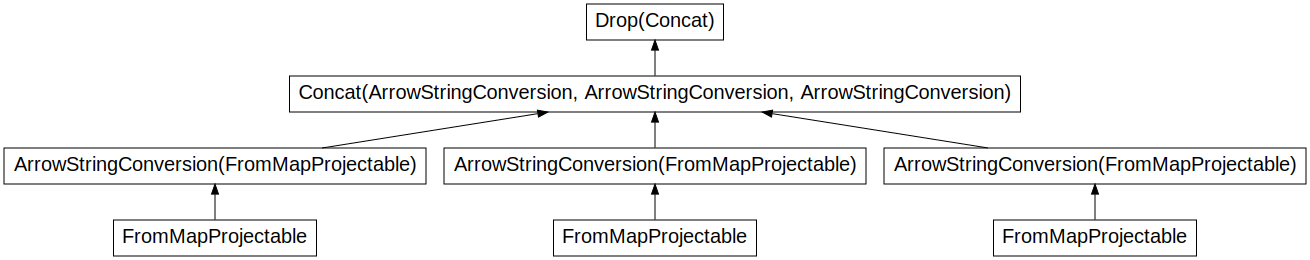

In [14]:
df_final.visualize()

In [15]:
df_final.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount
0,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,2.0,1.10,-73.990372,40.734695,1.0,N,-73.981842,40.732407,7.5
1,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,5.0,4.90,-73.980782,40.729912,1.0,N,-73.944473,40.716679,18.0
2,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,1.0,10.54,-73.984550,40.679565,1.0,N,-73.950272,40.788925,33.0
3,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,1.0,4.75,-73.993469,40.718990,1.0,N,-73.962242,40.657333,16.5
4,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,3.0,1.76,-73.960625,40.781330,1.0,N,-73.977264,40.758514,8.0
5,2.0,2016-01-01 00:00:00,2016-01-01 00:18:30,2.0,5.52,-73.980118,40.743050,1.0,N,-73.913490,40.763142,19.0
6,2.0,2016-01-01 00:00:00,2016-01-01 00:26:45,2.0,7.45,-73.994057,40.719990,1.0,N,-73.966362,40.789871,26.0
7,1.0,2016-01-01 00:00:01,2016-01-01 00:11:55,1.0,1.20,-73.979424,40.744614,1.0,N,-73.992035,40.753944,9.0
8,1.0,2016-01-01 00:00:02,2016-01-01 00:11:14,1.0,6.00,-73.947151,40.791046,1.0,N,-73.920769,40.865578,18.0
9,2.0,2016-01-01 00:00:02,2016-01-01 00:11:08,1.0,3.21,-73.998344,40.723896,1.0,N,-73.995850,40.688400,11.5


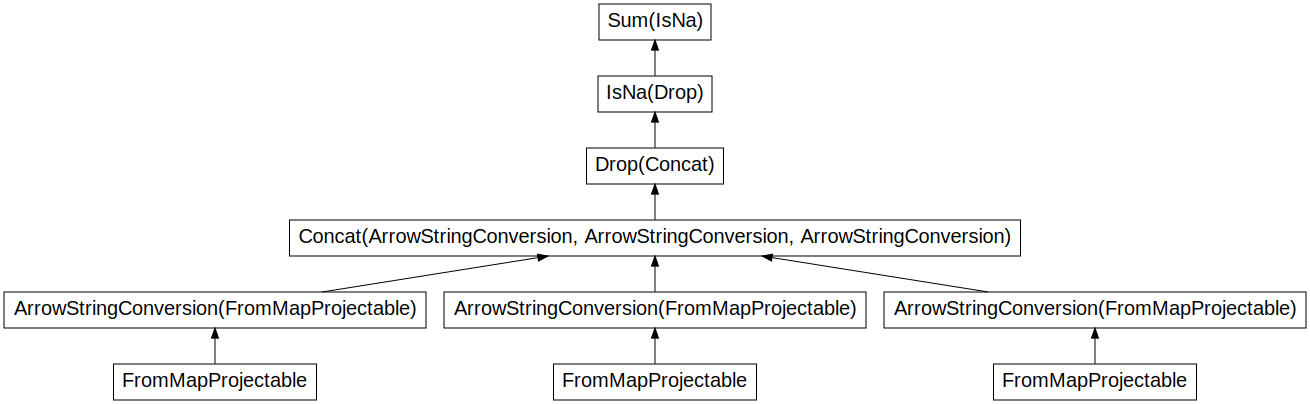

In [17]:
df_final.isna().sum().visualize()

In [16]:
df_final.isna().sum().compute()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
fare_amount              0
dtype: int64

## Analysis

In [19]:
sns.set_style("whitegrid")

In [20]:
df_final.describe().compute()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,fare_amount
count,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07
mean,1.532576e+00,1.661700e+00,5.309408e+00,-7.283942e+01,4.012605e+01,1.039150e+00,-7.290482e+01,4.016297e+01,1.257198e+01
std,4.989377e-01,1.316154e+00,4.672575e+03,9.090656e+00,5.007832e+00,5.564537e-01,8.828348e+00,4.863875e+00,9.179006e+01
min,1.000000e+00,0.000000e+00,-3.390584e+06,-1.616987e+02,-7.703949e+01,1.000000e+00,-1.616987e+02,-7.703949e+01,-9.576000e+02
25%,1.000000e+00,1.000000e+00,1.100000e+00,-7.399055e+01,4.074137e+01,1.000000e+00,-7.399009e+01,4.074001e+01,7.000000e+00
50%,2.000000e+00,1.000000e+00,1.930000e+00,-7.397922e+01,4.075640e+01,1.000000e+00,-7.397832e+01,4.075612e+01,1.000000e+01
75%,2.000000e+00,2.000000e+00,3.800000e+00,-7.396252e+01,4.076979e+01,1.000000e+00,-7.395599e+01,4.077166e+01,1.550000e+01
max,2.000000e+00,9.000000e+00,1.907263e+07,9.464387e+01,6.685682e+01,9.900000e+01,3.889659e+01,4.053167e+02,4.294967e+05


## Trip Distance

<Axes: ylabel='trip_distance'>

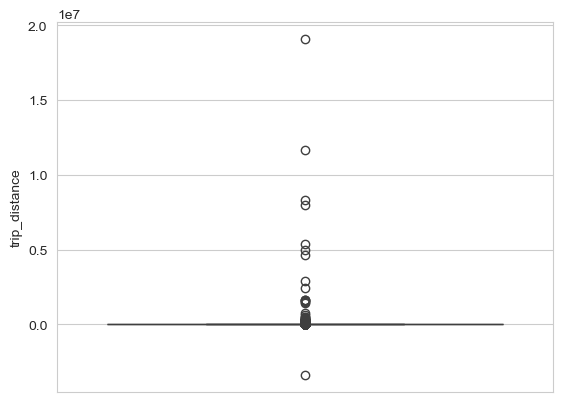

In [22]:
sns.boxplot(data=df_final['trip_distance'].compute())

In [25]:
# percentile values for trip distance
percentile_values = np.arange(0.1, 1.0, 0.1)
percentile_values

for percentile in percentile_values:
    print(f"The trip distance value for {int(percentile * 100)}th percentile is {df_final['trip_distance'].quantile(percentile).compute()}")

The trip distance value for 10th percentile is 0.7
The trip distance value for 20th percentile is 0.97
The trip distance value for 30th percentile is 1.23
The trip distance value for 40th percentile is 1.56
The trip distance value for 50th percentile is 1.93
The trip distance value for 60th percentile is 2.49
The trip distance value for 70th percentile is 3.27
The trip distance value for 80th percentile is 4.6
The trip distance value for 90th percentile is 8.3


In [26]:
percentile_values = np.arange(0.90, 1.01, 0.01)
percentile_values
for percentile in percentile_values:
    print(f"The trip distance value for {int(percentile * 100)}th percentile is {df_final['trip_distance'].quantile(percentile).compute()}")

The trip distance value for 90th percentile is 8.3
The trip distance value for 91th percentile is 8.91
The trip distance value for 92th percentile is 9.53
The trip distance value for 93th percentile is 10.2
The trip distance value for 94th percentile is 10.95
The trip distance value for 95th percentile is 12.1
The trip distance value for 96th percentile is 14.680000000000582
The trip distance value for 97th percentile is 16.91
The trip distance value for 98th percentile is 17.95
The trip distance value for 99th percentile is 19.375500000000464
The trip distance value for 100th percentile is 19072628.8


## Fare Amount

<Axes: ylabel='fare_amount'>

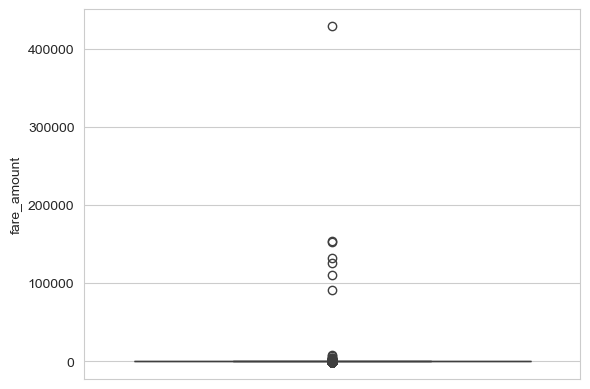

In [27]:
sns.boxplot(data=df_final['fare_amount'].compute())

In [28]:
# percentile values for fare amount
percentile_values = np.arange(0.1, 1.0, 0.1)
percentile_values

for percentile in percentile_values:
    print(f"The trip distance value for {int(percentile * 100)}th percentile is {df_final['fare_amount'].quantile(percentile).compute()}")

The trip distance value for 10th percentile is 5.0
The trip distance value for 20th percentile is 6.0
The trip distance value for 30th percentile is 7.5
The trip distance value for 40th percentile is 8.5
The trip distance value for 50th percentile is 10.0
The trip distance value for 60th percentile is 11.5
The trip distance value for 70th percentile is 14.0
The trip distance value for 80th percentile is 18.0
The trip distance value for 90th percentile is 27.0


In [29]:
# percentile values for fare amount
percentile_values = np.arange(0.90, 1.01, 0.01)
percentile_values

for percentile in percentile_values:
    print(f"The trip distance value for {int(percentile * 100)}th percentile is {df_final['fare_amount'].quantile(percentile).compute()}")

The trip distance value for 90th percentile is 27.0
The trip distance value for 91th percentile is 29.0
The trip distance value for 92th percentile is 30.5
The trip distance value for 93th percentile is 33.0
The trip distance value for 94th percentile is 35.5
The trip distance value for 95th percentile is 40.0
The trip distance value for 96th percentile is 49.5
The trip distance value for 97th percentile is 52.0
The trip distance value for 98th percentile is 52.0
The trip distance value for 99th percentile is 52.0
The trip distance value for 100th percentile is 429496.72


## Location Based Columns

In [31]:
location_subset = df_final[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
location_subset

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
npartitions=82,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


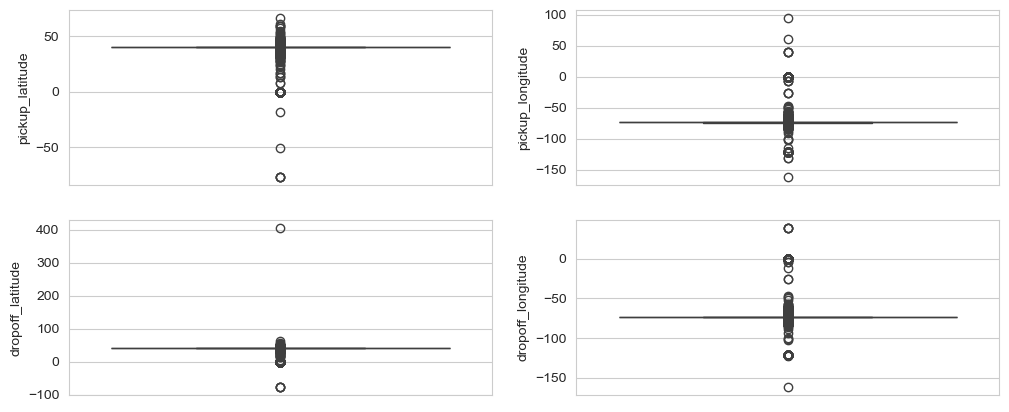

In [32]:
# box plot for location based columns
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
for i in range(4):
    if i <= 1:
        sns.boxplot(data=location_subset.iloc[:, i].compute(), ax=ax1[i])
    else:
        sns.boxplot(data=location_subset.iloc[:, i].compute(), ax=ax2[i-2])
    

## Datetime Columns

In [33]:
df_final.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'fare_amount'],
      dtype='object')

In [36]:
# convert the columns to datetime
df_final['tpep_pickup_datetime'] = dd.to_datetime(df_final['tpep_pickup_datetime'], yearfirst=True, format="mixed")
df_final['tpep_dropoff_datetime'] = dd.to_datetime(df_final['tpep_dropoff_datetime'],  yearfirst=True, format="mixed")

In [37]:
# create new columns
df_final['pickup_month'] = df_final['tpep_pickup_datetime'].dt.month
df_final['pickup_day_of_week'] = df_final['tpep_pickup_datetime'].dt.dayofweek
df_final['pickup_hour'] = df_final['tpep_pickup_datetime'].dt.hour


In [38]:
df_final.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'pickup_month',
       'pickup_day_of_week', 'pickup_hour'],
      dtype='object')

In [39]:
# pickups every 3 days

pickups_every_3_days = (
    df_final
    .set_index('tpep_pickup_datetime')
    .resample('3D')
    .size()
    .compute()
)

In [40]:
pickups_every_3_days

tpep_pickup_datetime
2016-01-01     960746
2016-01-04    1007938
2016-01-07    1162789
2016-01-10    1061829
2016-01-13    1192852
2016-01-16    1132536
2016-01-19    1166946
2016-01-22     658061
2016-01-25     968922
2016-01-28    1232734
2016-01-31    1065990
2016-02-03    1176173
2016-02-06    1144752
2016-02-09    1192598
2016-02-12    1285409
2016-02-15    1101217
2016-02-18    1256220
2016-02-21    1114674
2016-02-24    1251497
2016-02-27    1155024
2016-03-01    1208179
2016-03-04    1270530
2016-03-07    1106194
2016-03-10    1273983
2016-03-13    1134075
2016-03-16    1234570
2016-03-19    1176151
2016-03-22    1155525
2016-03-25    1149227
2016-03-28    1108463
2016-03-31     394055
Freq: 3D, dtype: int64

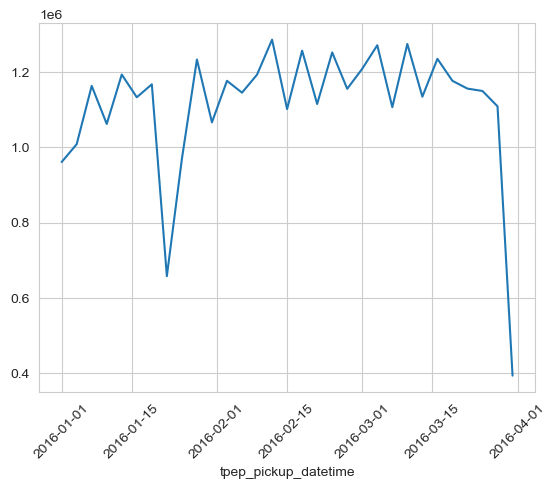

In [41]:
# plot the graph of pickups
sns.lineplot(pickups_every_3_days)
plt.xticks(rotation=45)
plt.show()

In [55]:
# pickup for each hour of the day
pickups_each_hour = (
    df_final
    .groupby(['pickup_hour', 'pickup_day_of_week'])['VendorID']
    .count()
    .compute()
)

In [62]:
pickup_each_hour = pickups_each_hour.reset_index()

In [63]:
pickup_each_hour.rename(columns={'VendorID': 'Number of Pickups'}, inplace=True)

In [64]:
pickup_each_hour

,pickup_hour,pickup_day_of_week,Number of Pickups
0,4,2,29498
1,4,3,32480
2,5,2,49844
3,6,2,136330
4,6,3,138392
...,...,...,...
163,23,5,299024
164,0,0,100903
165,0,1,101299
166,19,0,291911


In [65]:
day_names = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
replacement_mapper = {k: v for k, v in enumerate(day_names)}
replacement_mapper

{0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

In [66]:
pickup_each_hour.replace({'pickup_day_of_week': replacement_mapper}, inplace=True)

In [67]:
pickup_each_hour

,pickup_hour,pickup_day_of_week,Number of Pickups
0,4,Wed,29498
1,4,Thur,32480
2,5,Wed,49844
3,6,Wed,136330
4,6,Thur,138392
...,...,...,...
163,23,Sat,299024
164,0,Mon,100903
165,0,Tue,101299
166,19,Mon,291911


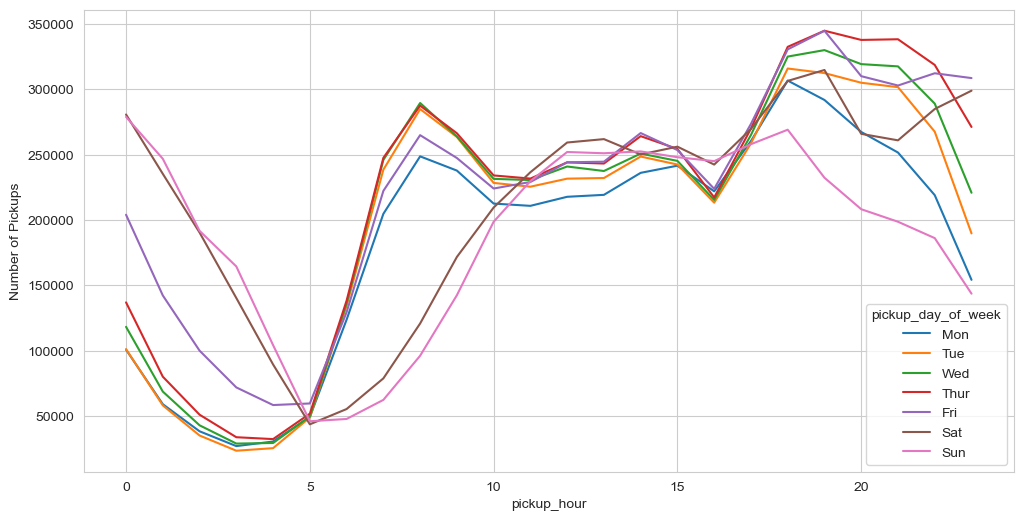

In [69]:
# plot the line plot
fig = plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pickup_each_hour, 
    x="pickup_hour", 
    y="Number of Pickups",
    hue="pickup_day_of_week",
    hue_order=day_names
)
plt.show()
